### Import Libraries and Get Location Data

In [1]:
#Required libraries FOR:

#data processing
import numpy as np
import pandas as pd
import json
from os import path

#web scraping
import urllib.request
from bs4 import BeautifulSoup

#plotting maps
#!conda install -c conda-forge folium --yes
#I have Ubuntu on my laptop so 
#!pip3 install folium
import folium

#retrieving latitude-longitude of Neighbors
from geopy.geocoders import Nominatim

#clustering
#!pip3 install --upgrade scipy
#!pip3 install --upgrade scikit-learn
from sklearn.cluster import KMeans

#getting data and conversion from JSON
import requests
from pandas.io.json import json_normalize

#plotting libraries
import matplotlib.pyplot as plt

In [2]:
if not path.exists('newyork_data.json'):
    !wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
else:
    print("Data is already downloaded!")

Data is already downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods_data = newyork_data['features']

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
queen_neigh = neighborhoods[neighborhoods['Borough']=='Queens'].reset_index(drop=True)
brook_neigh = neighborhoods[neighborhoods['Borough']=='Brooklyn'].reset_index(drop=True)

#bronx_neigh.head(10)

### Plot regions of Interest

In [7]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="brook_explorer")
location = geolocator.geocode(address)
b_latitude = location.latitude
b_longitude = location.longitude
#print('The geograpical coordinate of Brooklyn are {}, {}.'.format(b_latitude, b_longitude))

address = 'Queens, NY'

geolocator = Nominatim(user_agent="queen_explorer")
location = geolocator.geocode(address)
q_latitude = location.latitude
q_longitude = location.longitude
#print('The geograpical coordinate of Queens are {}, {}.'.format(q_latitude, q_longitude))

latitude=np.mean([b_latitude,q_latitude])
longitude=np.mean([b_longitude,q_longitude])

In [8]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers for queens to map (blue)
for lat, lng, borough, neighborhood in zip(queen_neigh['Latitude'], queen_neigh['Longitude'], queen_neigh['Borough'], queen_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  

# add markers for brooklyn to map (red)
for lat, lng, borough, neighborhood in zip(brook_neigh['Latitude'], brook_neigh['Longitude'], brook_neigh['Borough'], brook_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc3139',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  

map_newyork

### Get Venues Data from Foursquare

In [9]:
CLIENT_ID = 'RYCX141XUBTJKRVJMLA51KZVARP4KANFZDUVGY4SNPBT0JV0' # your Foursquare ID
CLIENT_SECRET = 'BRS3PNN0IUEIUAJ4LYDWJ0EWFVVA22FKZMCUHC4331QBADIH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [10]:
def getNearbyVenues(borough,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT=200
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        fname = '%s' % name
        if not path.exists('Data/'+borough+fname.replace(" ","")+'.json'):
            results = requests.get(url).json()["response"]['groups'][0]['items']
            with open('Data/'+borough+fname.replace(" ","")+'.json', 'w') as f:
                json.dump(results, f)
        else:
            #print('File {} exists!'.format('Data/'+fname.replace(" ","")+'.json'))
            with open('Data/'+borough+fname.replace(" ","")+'.json') as f:
              results = json.load(f)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['icon']['prefix']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'prefix']
    
    return(nearby_venues)

In [11]:
queen_venues = getNearbyVenues('Queens/',names=queen_neigh['Neighborhood'],
                                   latitudes=queen_neigh['Latitude'],
                                   longitudes=queen_neigh['Longitude']
                                  )
brook_venues = getNearbyVenues('Brooklyn/',names=brook_neigh['Neighborhood'],
                                   latitudes=brook_neigh['Latitude'],
                                   longitudes=brook_neigh['Longitude']
                                  )

## Section 1 : Food Venues

In [12]:
#Pick only venues categorized under "Food"
brook_food_venues = pd.DataFrame(columns=list(brook_venues))[:-1]
for i in range(brook_venues.shape[0]):
    if not brook_venues.iloc[i]['prefix'].find('/food/')==-1:
        brook_food_venues=brook_food_venues.append(brook_venues.iloc[i])
brook_food_venues = brook_food_venues.drop(['prefix'],axis=1).reset_index(drop=True)

queen_food_venues = pd.DataFrame(columns=list(queen_venues))[:-1]
for i in range(queen_venues.shape[0]):
    if not queen_venues.iloc[i]['prefix'].find('/food/')==-1:
        queen_food_venues=queen_food_venues.append(queen_venues.iloc[i])
queen_food_venues = queen_food_venues.drop(['prefix'],axis=1).reset_index(drop=True)    

In [13]:
#Split "Food" venues into Restaurants and Otherfood
brook_restaurants = pd.DataFrame(columns=list(brook_food_venues))
brook_otherfood = pd.DataFrame(columns=list(brook_food_venues))
for i in range(brook_food_venues.shape[0]):
    if not brook_food_venues.iloc[i]['Venue Category'].find('Restaurant')==-1:
        brook_restaurants=brook_restaurants.append(brook_food_venues.iloc[i])
    else:
        brook_otherfood=brook_otherfood.append(brook_food_venues.iloc[i])
brook_restaurants = brook_restaurants.reset_index(drop=True)
brook_otherfood = brook_otherfood.reset_index(drop=True)

queen_restaurants = pd.DataFrame(columns=list(queen_food_venues))
queen_otherfood = pd.DataFrame(columns=list(queen_food_venues))
for i in range(queen_food_venues.shape[0]):
    if not queen_food_venues.iloc[i]['Venue Category'].find('Restaurant')==-1:
        queen_restaurants=queen_restaurants.append(queen_food_venues.iloc[i])
    else:
        queen_otherfood=queen_otherfood.append(queen_food_venues.iloc[i])
queen_restaurants = queen_restaurants.reset_index(drop=True)
queen_otherfood = queen_otherfood.reset_index(drop=True)

### Analysis of Cousin Origins

In [14]:
#Split restaurant types in to 15 groups based on their frequencies
b_rest_freq_list=brook_restaurants['Venue Category'].value_counts(normalize=False).index.tolist()[:14]
b_rest_freq_list.append('Others')
b_rest_freqs=brook_restaurants['Venue Category'].value_counts(normalize=False).values.tolist()[:14]
b_last = np.array(brook_restaurants['Venue Category'].value_counts(normalize=False).values.tolist()[14:]).sum()
b_rest_freqs.append(b_last)

q_rest_freq_list=queen_restaurants['Venue Category'].value_counts(normalize=False).index.tolist()[:14]
q_rest_freq_list.append('Others')
q_last = np.array(queen_restaurants['Venue Category'].value_counts(normalize=False).values.tolist()[14:]).sum()
q_rest_freqs=queen_restaurants['Venue Category'].value_counts(normalize=False).values.tolist()[:14]
q_rest_freqs.append(q_last)

In [15]:
b_rest_freq_list, b_rest_freqs

(['Italian Restaurant',
  'Chinese Restaurant',
  'Mexican Restaurant',
  'American Restaurant',
  'Caribbean Restaurant',
  'Restaurant',
  'Thai Restaurant',
  'Sushi Restaurant',
  'Japanese Restaurant',
  'Fast Food Restaurant',
  'Latin American Restaurant',
  'Seafood Restaurant',
  'Middle Eastern Restaurant',
  'French Restaurant',
  'Others'],
 [61, 53, 50, 42, 35, 29, 28, 28, 24, 21, 21, 17, 17, 17, 182])

In [16]:
q_rest_freq_list, q_rest_freqs

(['Chinese Restaurant',
  'Korean Restaurant',
  'Italian Restaurant',
  'Mexican Restaurant',
  'Latin American Restaurant',
  'Fast Food Restaurant',
  'Thai Restaurant',
  'Sushi Restaurant',
  'Indian Restaurant',
  'American Restaurant',
  'Caribbean Restaurant',
  'Japanese Restaurant',
  'Greek Restaurant',
  'South American Restaurant',
  'Others'],
 [60, 40, 36, 32, 31, 26, 26, 24, 20, 19, 19, 18, 15, 15, 179])

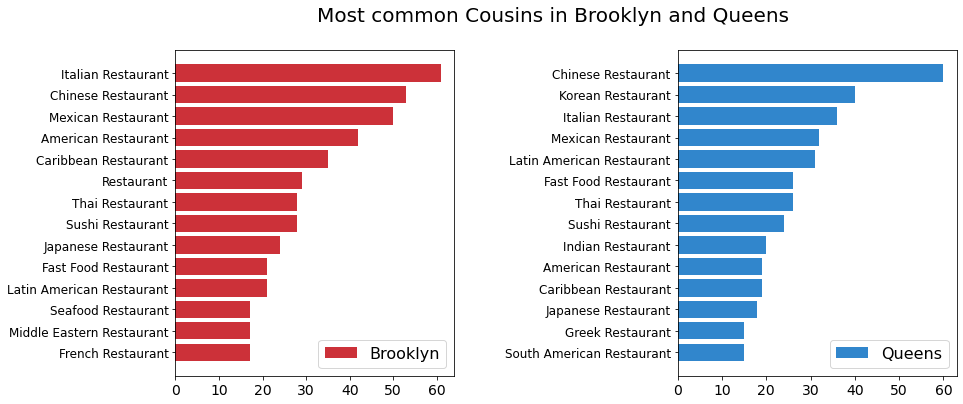

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
fig.subplots_adjust(left=None,right=None,wspace=0.8)
fig.suptitle('Most common Cousins in Brooklyn and Queens',fontsize=20)
plt.sca(axes[0])
plt.barh(b_rest_freq_list[:-1][::-1],b_rest_freqs[:-1][::-1],color='#cc3139')
plt.xticks(rotation=0,fontsize=14)
plt.yticks(fontsize=12)
plt.legend(['Brooklyn'],fontsize=16)

plt.sca(axes[1])
plt.barh(q_rest_freq_list[:-1][::-1],q_rest_freqs[:-1][::-1],color='#3186cc')
plt.xticks(rotation=0,fontsize=14)
plt.yticks(fontsize=12)
plt.legend(['Queens'],fontsize=16)
plt.show()

### Analysis of Food venue Types

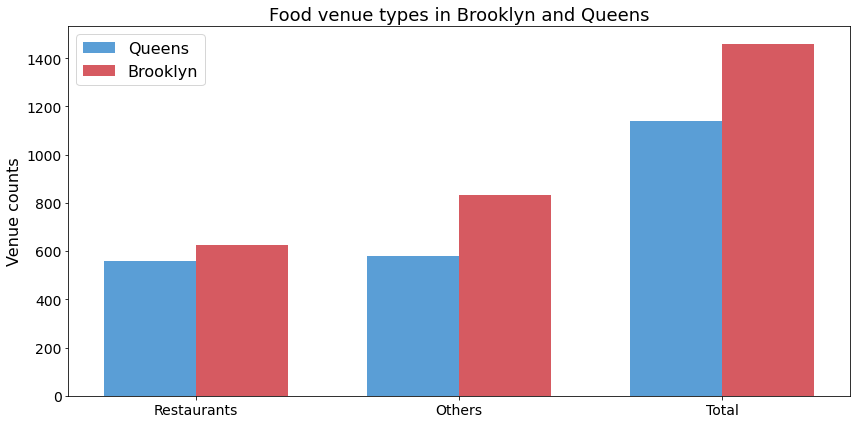

In [30]:
#Here we compare food venues in both boroghs
# data to plot
n_groups = 3
queen_food_vals = [queen_restaurants.shape[0],queen_otherfood.shape[0],queen_food_venues.shape[0]]
brook_food_vals = [brook_restaurants.shape[0],brook_otherfood.shape[0],brook_food_venues.shape[0]]

# create plot
fig, ax = plt.subplots(figsize=(12,6))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, queen_food_vals, bar_width,
alpha=opacity,
color='#3186cc',
label='Queens')

rects2 = plt.bar(index + bar_width, brook_food_vals, bar_width,
alpha=opacity,
color='#cc3139',
label='Brooklyn')

#plt.xlabel('Venue type')
plt.ylabel('Venue counts',fontsize=16)
plt.title('Food venue types in Brooklyn and Queens',fontsize=18)
plt.xticks(index + bar_width/2, ('Restaurants', 'Others', 'Total'),fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

plt.tight_layout()
plt.show()

## Section 2 : Art & Entertainment Venues, and Analysis

In [19]:
#Pick only venues categorized under "Arts & Entertainment"
brook_art_venues = pd.DataFrame(columns=list(brook_venues))[:-1]
for i in range(brook_venues.shape[0]):
    if not brook_venues.iloc[i]['prefix'].find('/arts_entertainment/')==-1:
        brook_art_venues=brook_art_venues.append(brook_venues.iloc[i])
brook_art_venues = brook_art_venues.drop(['prefix'],axis=1).reset_index(drop=True)

queen_art_venues = pd.DataFrame(columns=list(brook_venues))[:-1]
for i in range(queen_venues.shape[0]):
    if not queen_venues.iloc[i]['prefix'].find('/arts_entertainment/')==-1:
        queen_art_venues=queen_art_venues.append(queen_venues.iloc[i])
queen_art_venues = queen_art_venues.drop(['prefix'],axis=1).reset_index(drop=True)



In [20]:
queen_art_venues['Venue Category'].unique().shape

(19,)

In [21]:
q_art_freq_list=queen_art_venues['Venue Category'].value_counts(normalize=False).index.tolist()
q_art_freqs=queen_art_venues['Venue Category'].value_counts(normalize=False).values.tolist()
b_art_freq_list=brook_art_venues['Venue Category'].value_counts(normalize=False).index.tolist()
b_art_freqs=brook_art_venues['Venue Category'].value_counts(normalize=False).values.tolist()

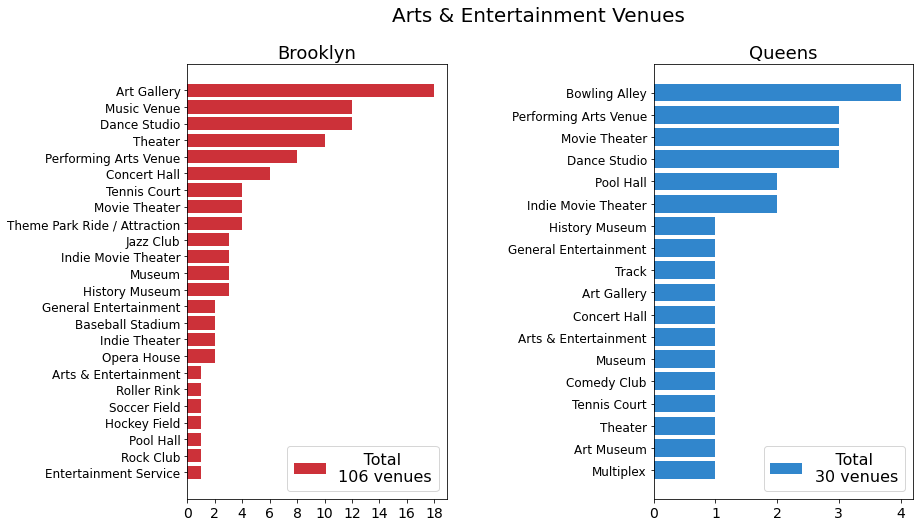

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(13,8))
fig.subplots_adjust(left=None,right=None,wspace=0.8)
fig.suptitle('Arts & Entertainment Venues',fontsize=20)
plt.sca(axes[0])
plt.title('Brooklyn',fontsize=18)
plt.barh(b_art_freq_list[:-1][::-1],b_art_freqs[:-1][::-1],color='#cc3139')
plt.xticks(np.arange(19)[::2],rotation=0,fontsize=14)
plt.yticks(fontsize=12)
total=brook_art_venues['Venue Category'].shape[0]
plt.legend(['     Total\n'+str(total)+' venues'],fontsize=16)

plt.sca(axes[1])
plt.title('Queens',fontsize=18)
plt.barh(q_art_freq_list[:-1][::-1],q_art_freqs[:-1][::-1],color='#3186cc')
plt.xticks(np.arange(5),rotation=0,fontsize=14)
plt.yticks(fontsize=12)
total=queen_art_venues['Venue Category'].shape[0]
plt.legend(['    Total\n'+str(total)+' venues'],fontsize=16)
plt.show()

## Section 3 : Colleges & University Venues, and Analysis

In [23]:
LIMIT = 200
radius = 2000
categoryId="4d4b7105d754a06372d81259"
query="college"
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    b_latitude, 
    b_longitude, 
    radius, 
    categoryId,
    LIMIT)
#url # display URL
   
fname = 'Data/Brooklyn_Education'+'.json'
if not path.exists(fname):
    results = requests.get(url).json()["response"]['groups'][0]['items']
    with open(fname, 'w') as f:
        json.dump(results, f)
else:
    #print('File {} exists!'.format('Data/'+fname.replace(" ","")+'.json'))
    with open(fname) as f:
        results = json.load(f)

venues_list=[]
venues_list.append([(
    'Brooklyn', 
    lat, 
    lng, 
    v['venue']['name'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['categories'][0]['name']) for v in results])

brook_edu_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
brook_edu_venues.columns = ['Neighborhood', 
                'Neighborhood Latitude', 
                'Neighborhood Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']

In [24]:
brook_edu_venues.shape

(54, 7)

In [25]:
LIMIT = 200
radius = 2000
categoryId="4d4b7105d754a06372d81259"
query="college"
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    q_latitude, 
    q_longitude, 
    radius, 
    categoryId,
    LIMIT)
#url # display URL

fname = 'Data/Queens_Education'+'.json'
if not path.exists(fname):
    results = requests.get(url).json()["response"]['groups'][0]['items']
    with open(fname, 'w') as f:
        json.dump(results, f)
else:
    #print('File {} exists!'.format('Data/'+fname.replace(" ","")+'.json'))
    with open(fname) as f:
        results = json.load(f)

venues_list=[]
venues_list.append([(
    'Queens', 
    lat, 
    lng, 
    v['venue']['name'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['categories'][0]['name']) for v in results])

queen_edu_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
queen_edu_venues.columns = ['Neighborhood', 
                'Neighborhood Latitude', 
                'Neighborhood Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']

In [26]:
queen_cols_univs = pd.DataFrame(columns=list(queen_edu_venues))[:-1]
for i in range(queen_edu_venues.shape[0]):
    col=queen_edu_venues.iloc[i]['Venue Category'].find('College')
    univ=queen_edu_venues.iloc[i]['Venue Category'].find('University')
    if not (col==-1 and univ==-1):
        queen_cols_univs=queen_cols_univs.append(queen_edu_venues.iloc[i])
queen_cols_univs = queen_cols_univs.reset_index(drop=True)

In [27]:
brook_cols_univs = pd.DataFrame(columns=list(brook_edu_venues))[:-1]
for i in range(brook_edu_venues.shape[0]):
    col=brook_edu_venues.iloc[i]['Venue Category'].find('College')
    univ=brook_edu_venues.iloc[i]['Venue Category'].find('University')
    if not (col==-1 and univ==-1):
        brook_cols_univs=brook_cols_univs.append(brook_edu_venues.iloc[i])
brook_cols_univs = brook_cols_univs.reset_index(drop=True)

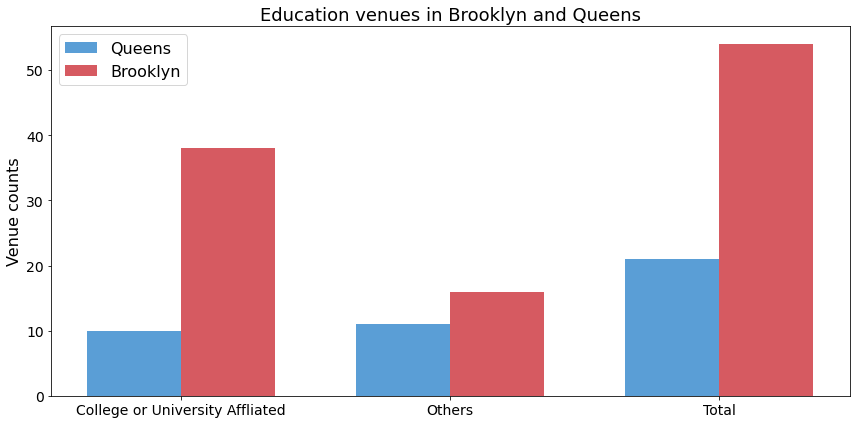

In [28]:
#Here we compare food venues in both boroghs
# data to plot
n_groups = 3
queen_edu_vals = [queen_cols_univs.shape[0],queen_edu_venues.shape[0]-queen_cols_univs.shape[0],queen_edu_venues.shape[0]]
brook_edu_vals = [brook_cols_univs.shape[0],brook_edu_venues.shape[0]-brook_cols_univs.shape[0],brook_edu_venues.shape[0]]

# create plot
fig, ax = plt.subplots(figsize=(12,6))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, queen_edu_vals, bar_width,
alpha=opacity,
color='#3186cc',
label='Queens')

rects2 = plt.bar(index + bar_width, brook_edu_vals, bar_width,
alpha=opacity,
color='#cc3139',
label='Brooklyn')

#plt.xlabel('Venue type')
plt.ylabel('Venue counts',fontsize=16)
plt.title('Education venues in Brooklyn and Queens',fontsize=18)
plt.xticks(index + bar_width/2, ('College or University Affliated', 'Others', 'Total'),fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

plt.tight_layout()
plt.show()